####DOMAIN: Social media analytics

• CONTEXT: Past studies in Sarcasm Detection mostly make use of Twitter datasets collected
using hashtag based supervision but such datasets are noisy in terms of labels and
language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in
these requires the availability of contextual tweets.In this hands-on project, the goal is to
build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

• DATA DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com.
This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in
teasing apart the real sarcastic elements
Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data
Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

• PROJECT OBJECTIVE: Build a sequential NLP classifier which can use input text parameters
to determine the customer sentiments.

In [1]:
# Import Libraries

# used to supress display of warnings
import warnings

# os is used to provide a way of using operating system dependent functionality
# We use it for setting working folder
import os

# Pandas is used for data manipulation and analysis
import pandas as pd 

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays 
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns
import tensorflow 
print(tensorflow.__version__)

2.7.0


In [2]:
# Setting options
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

In [3]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read the data
df =pd.read_json("/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json", lines = True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df.shape

(28619, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [7]:
df["is_sarcastic"].unique()

array([1, 0])

In [8]:
df["is_sarcastic"].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

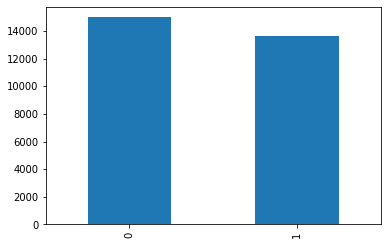

In [9]:
df["is_sarcastic"].value_counts().plot(kind = "bar")

In [10]:
# Check for missing values
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [11]:
# dropping article_link column
df = df.drop(["article_link"], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [12]:
# Length of each sentence
df["length"] = df["headline"].apply(lambda x:len(x.split(" ")))
df.head()

,is_sarcastic,headline,length
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9


In [13]:
df["length"].describe()

count   28619.0000000
mean       10.0518537
std         3.3909385
min         2.0000000
25%         8.0000000
50%        10.0000000
75%        12.0000000
max       151.0000000
Name: length, dtype: float64

In [14]:
#Lowercase
df["headline"] = df["headline"].apply(lambda x: x.lower())

In [15]:
# Remove punctuatios
df["headline"] = df["headline"].str.replace('[^\w\s]','')
df.head()

,is_sarcastic,headline,length
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep totally nails why congress is falling ...,13
2,0,eat your veggies 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word stream...,9


In [16]:
# Defining Parameters
max_features = 20000
maxlen = 100
embedding_size = 50

Get indices for words

In [17]:
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(num_words= max_features)

In [18]:
tokenizer.fit_on_texts(list(df["headline"]))
X = tokenizer.texts_to_sequences(df["headline"])
X[0]

[15525, 336, 3105, 6322, 2318, 2, 671, 1138]

In [19]:
print("Number of samples tokenized", len(X))

Number of samples tokenized 28619


In [20]:
# Creating features and labels
X = tensorflow.keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen)
y=np.asarray(df["is_sarcastic"])

In [21]:
print(y[0])
print(X.shape)

1
(28619, 100)


In [22]:
# Total no words
num_words = len(tokenizer.word_index) + 1
print("Total words: ", num_words)

Total words:  29654


Creating a weight matrix using GloVe embeddings

In [23]:
EMBEDDING_FILE = "/content/drive/MyDrive/glove.6B.50d.txt"
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [24]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 50))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [25]:
# Split the data into Train & Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [26]:
# Bidirectional LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten
from functools import partial

model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length=maxlen))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

In [27]:
# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           1482700   
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         183296    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 100, 256)          0         
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 256)               6553856   
                                                        

In [29]:
#Fitting the model
batch_size = 64
epochs = 50

from tensorflow.keras.callbacks import ModelCheckpoint
callback = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3, restore_best_weights=True,mode="min")

training_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/50
314/314 [==============================] - 13s 21ms/step - loss: 0.5180 - accuracy: 0.7411 - val_loss: 0.4140 - val_accuracy: 0.8028
Epoch 2/50
314/314 [==============================] - 6s 18ms/step - loss: 0.3534 - accuracy: 0.8450 - val_loss: 0.3295 - val_accuracy: 0.8558
Epoch 3/50
314/314 [==============================] - 6s 19ms/step - loss: 0.2791 - accuracy: 0.8854 - val_loss: 0.2999 - val_accuracy: 0.8719
Epoch 4/50
314/314 [==============================] - 6s 18ms/step - loss: 0.2186 - accuracy: 0.9085 - val_loss: 0.2987 - val_accuracy: 0.8721
Epoch 5/50
314/314 [==============================] - 6s 18ms/step - loss: 0.1770 - accuracy: 0.9305 - val_loss: 0.3093 - val_accuracy: 0.8839
Epoch 6/50
314/314 [==============================] - 6s 18ms/step - loss: 0.1380 - accuracy: 0.9471 - val_loss: 0.3399 - val_accuracy: 0.8813
Epoch 7/50
314/314 [==============================] - 6s 18ms/step - loss: 0.1143 - accuracy: 0.9564 - val_loss: 0.3358 - val_accuracy: 0.880

In [30]:
y_pred = model.predict(X_test.reshape(len(X_test), 100))

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, np.around(y_pred))

array([[4045,  451],
       [ 594, 3496]])

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.around(y_pred))

0.8782902399254601

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.around(y_pred)))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4496
           1       0.89      0.85      0.87      4090

    accuracy                           0.88      8586
   macro avg       0.88      0.88      0.88      8586
weighted avg       0.88      0.88      0.88      8586



Text(0.5, 1.0, 'Training and validation loss')

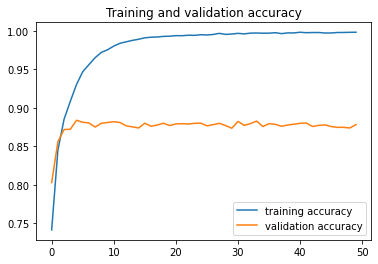

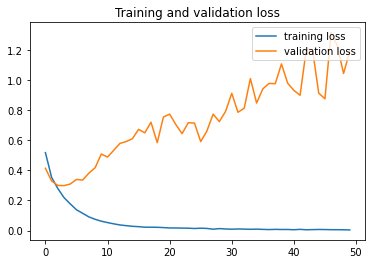

In [34]:
# Display plot of training and validation loss/accuracy wrt to epochs
import matplotlib.pyplot as plt
accuracy      = training_history.history['accuracy']
val_accuracy  = training_history.history['val_accuracy']
loss     = training_history.history['loss']
val_loss = training_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss' )
plt.plot  ( epochs, val_loss, label = 'validation loss' )
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss'   )